In [1]:
cd ./cosmo-field/

/mnt/home/tmakinen/repositories/imnn/cosmo-field


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from IMNN import IMNN
from IMNN.LFI import LFI
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfd = tfp.distributions



# for autograd functions
#import jax.numpy as jnp
#from jax import grad, jit, vmap
#from jax import random
#import jax.scipy.special as jspecial

#import numpyro
#import numpyro
#import numpyro.distributions as dist

#key = random.PRNGKey(0)


print("IMNN {}\nTensorFlow {}\nTensorFlow Probability {}\nnumpy {}".format(
    IMNN.__version__, tf.__version__, tfp.__version__, np.__version__))

IMNN 0.2a5
TensorFlow 2.3.0
TensorFlow Probability 0.11.0
numpy 1.18.5


In [2]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type  == "GPU"]

In [3]:
get_available_gpus()

['/device:GPU:0']

In [4]:
print(tf.__version__)

2.3.0


# IMNN power spectrum model
Let's try to find a toy problem in which methods like the linear MOPED method fails to recover accurate fiducial parameters, and the IMNN (perhaps) succeeds. Let's start by generating 2D Gaussian maps according to the power law
$$ P(k) = Ak^{-B} $$
where the "cosmological" amplitude $A$ and power law $B$ are our two parameters of interest. We'll first start by varying just these two parameters, but it will be interesting then to consider a foreground contribution
$$ P_{\rm fg} = Ck^{-D} $$
(maybe with a much larger variance?) where $C >> A$ such that the cosmological field is obscured by a smoother, more intense foreground. Can the IMNN network pick out these parameters ?

TODO:
- Train convolutional IMNN on increasing $C$ (and varied $D$ ?) to see where NN breaks ... incorporate trainable BatchNormalization ?
- Incorporate higher order power spectrum (toy model for non-gaussianity) and see if we can pick out residual non-gaussianity, e.g. $\Phi_{\rm non}(\vec{x}) = \Phi_{\rm obs}(\vec{x}) - \Phi_{\rm gauss}(\vec{x})$

___

# analytic likelihood for power spectrum
For a power spectrum indexed by $k_i$, $i=1, \dots, m$, the analytic likelihood assuming the above model with parameters $\theta = \{A,B\}$ is
$$ \mathcal{L}(\vec{d} | \theta) = \frac{1}{\sqrt{(2\pi)^m \delta P(k_1) \delta P(k_2), \dots \delta P(k_m)}} \times \exp \left( -\frac{1}{2} \sum_{i=1}^{m} \frac{P(k_i) - A k_i^B}{\delta P(k_i)} \right)$$

Our IMNN should be able to pick out these parameters and approximate the analytic likelihood
(TODO: code up max likelihood inference w/ MCMC)

In [5]:
import argparse
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IMNN.utils import TFRecords
from IMNN.LFI.LFI import GaussianApproximation

from FyeldGenerator import generate_field


__version__ = "0.2a5"
__author__ = "Lucas Makinen"

# HERE θ_fid is [A,B], yielding power spectrum P(k) = A k^-B

class GenerateCosmoField():
    def __init__(self, input_shape=(1,128,128), n_params=2, n_summaries=2, n_s=1000, n_d=1000, n_d_small=100,
                 θ_fid=np.array([1.0, 0.5]), δθ=np.array([0.2, 0.1]), θ_fg=None, training_seed=0,
                 validation_seed=1):
        
        self.input_shape = input_shape
        self.n_params = n_params
        self.n_summaries = n_summaries
        self.n_s = n_s
        self.n_d = n_d
        self.n_d_small = n_d_small
        self.θ_fid = θ_fid
        self.δθ = δθ
        self.half_δθ = δθ / 2.
        self.training_seed = training_seed
        self.validation_seed = validation_seed
        self.θ_fg = θ_fg

    def get_fiducial(self, seed, data):
        return data[seed]

    def get_derivative(self, seed, derivative, parameter, data):
        return data[seed, derivative, parameter]

    def check_selection(self, size):
        if size not in ["full", "all", "small"]:
            print("size must be `full`, `all` or `small` describing, respectively "
                  "whether just `n_d=n_s` is returned, or `n_d=n_s` and `n_d_small` "
                  "is returned, or `n_d=n_d_small` is returned.")
            sys.exit()
    
    def check_ftype(self, ftype):
        if ftype not in ["both", "numpy", "tfrecords"]:
            print("size must be `both`, `numpy` or `tfrecords` describing, respectively "
                  "whether both `numpy` and `tfrecords` files are saved, or just either one.")
            sys.exit()

    # Helper that generates power-law power spectrum
    def Pkgen(self, n, amp=1):
        def Pk(k):
            return amp*np.power(k, -n)

        return Pk

    # Draw samples from a normal distribution
    def distrib(self, shape):
        a = np.random.normal(loc=0, scale=1, size=shape)
        b = np.random.normal(loc=0, scale=1, size=shape)
        return a + 1j * b

    def simulator(self, parameters, θ_fg=None, seed=None, save_fg_copy=False,
                  fg_repeat=False,
                  simulator_args=None):
        # if self.input_shape[0] // 3 != 0:
        #     raise AssertionError ("input shape must be divisible by coordinate dimensions !")
        if seed is not None:
            np.random.seed(seed)
        if len(parameters.shape) == 1:
            parameters = parameters[np.newaxis, :]
        if self.n_params == 1:
            parameters = np.repeat(parameters, 2, axis=1)
            parameters[:, 0] = np.zeros_like(parameters[:, 0])

        
        d = np.array([generate_field(self.distrib, self.Pkgen(parameters[i,1], amp=parameters[i,0]), (self.input_shape[1], self.input_shape[2])) 
                      for i in range(parameters.shape[0])])
        
        
        if θ_fg is not None:
            if fg_repeat:
                θ_fg = np.repeat(
                  θ_fg[np.newaxis, :], 
                  parameters.shape[0], 
                  axis=0)
            fg = np.array([generate_field(self.distrib, self.Pkgen(self.θ_fg[1], 
                      amp=self.θ_fg[0]), (self.input_shape[1], self.input_shape[2])) 
                      for i in range(parameters.shape[0])])
        
            # return cosmo, fg separately
            if save_fg_copy:
                return d,fg     
            else:
                # add cosmo and fg
                d += fg; del fg
                return np.expand_dims(d, axis=1)
                
        # else return just cosmo
        else:
            d = np.expand_dims(d, axis=1)
            return d

    def generate_data(self, size="full"):
        self.check_selection(size)
        details = dict(
          input_shape=self.input_shape,
          n_params=self.n_params,
          n_summaries=self.n_summaries,
          n_s=self.n_s,
          n_d=self.n_d,
          θ_fid=self.θ_fid,
          θ_fg = self.θ_fg,
          δθ=self.δθ)
        
        # if foregrounds present, expand params
        if self.θ_fg is not None:
            fg_parameters = np.repeat(
                  self.θ_fg[np.newaxis, :], 
                  self.n_s, 
                  axis=0)
        else:
            fg_parameters = None

        # training base sims
        a_0 = self.simulator(
          parameters=np.repeat(
              self.θ_fid[np.newaxis, :], 
              self.n_s, 
              axis=0),
          θ_fg=fg_parameters,
          seed=self.training_seed,
          simulator_args={"input_shape": self.input_shape})
        # validation base sims
        a_1 = self.simulator(
          parameters=np.repeat(
              self.θ_fid[np.newaxis, :], 
              self.n_s, 
              axis=0),
          θ_fg=fg_parameters,
          seed=self.validation_seed,
          simulator_args={"input_shape": self.input_shape})

        # FOR NOW: TWO parameters: ONLY vary amp and power
        # training -theta
        b_0 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0] - self.half_δθ[0],
                  self.θ_fid[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          θ_fg=fg_parameters,
          seed=self.training_seed,
          simulator_args={"input_shape": self.input_shape})
        # validation -theta
        b_1 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0] - self.half_δθ[0],
                  self.θ_fid[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          θ_fg=fg_parameters,
          seed=self.validation_seed,
          simulator_args={"input_shape": self.input_shape})    
        # training +theta  
        c_0 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0] + self.half_δθ[0],
                  self.θ_fid[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          θ_fg=fg_parameters,
          seed=self.training_seed,
          simulator_args={"input_shape": self.input_shape})
        # validation +theta
        c_1 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0] + self.half_δθ[0],
                  self.θ_fid[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          θ_fg=fg_parameters,
          seed=self.validation_seed,
          simulator_args={"input_shape": self.input_shape})
        # training -sigma2theta
        d_0 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0], 
                  self.θ_fid[1] - self.half_δθ[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          θ_fg=fg_parameters,
          seed=self.training_seed,
          simulator_args={"input_shape": self.input_shape})
        # validation -sigma2theta
        d_1 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0], 
                  self.θ_fid[1] - self.half_δθ[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          θ_fg=fg_parameters,
          seed=self.validation_seed,
          simulator_args={"input_shape": self.input_shape})  
        # training +sigma2theta     
        e_0 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0], 
                  self.θ_fid[1] + self.half_δθ[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          θ_fg=fg_parameters,
          seed=self.training_seed,
          simulator_args={"input_shape": self.input_shape})
        # validation +sigma2theta
        e_1 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0], 
                  self.θ_fid[1] + self.half_δθ[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          θ_fg=fg_parameters,
          seed=self.validation_seed,
          simulator_args={"input_shape": self.input_shape}) 

        print('b0 shape : ', b_0.shape)
            
        f_0 = np.stack((np.stack((b_0, c_0)), 
                          np.stack((d_0, e_0)))
                        ).transpose(2, 1, 0, 3, 4, 5)
        f_1 = np.stack((np.stack((b_1, c_1)), 
                          np.stack((d_1, e_1)))
                        ).transpose(2, 1, 0, 3, 4, 5)

        result = (details, a_0, a_1, f_0, f_1)
          
        if size == "all":
            details["n_d_small"] = self.n_d_small
            result += (f_0[:self.n_d_small],
                    f_1[:self.n_d_small])
        elif size == "small":
            details["n_d"] = self.n_d_small
            result[-2] = f_0[:self.n_d_small]
            result[-1] = f_1[:self.n_d_small]

        return result
    
    def save(self, ftype="both", size="full", directory="data", record_size=0.01):
        self.check_ftype(ftype)
        result = self.generate_data(size=size)
        
        if (ftype=="both") or (ftype=="numpy"):
            np.savez("{}/details.npz".format(directory), result[0])
            np.save("{}/fiducial.npy".format(directory), result[1])
            np.save("{}/validation_fiducial.npy".format(directory), result[2])    
            np.save("{}/derivative.npy".format(directory), result[3])
            np.save("{}/validation_derivative.npy".format(directory), result[4])
            if size == "all":
                np.save("{}/derivative_small.npy".format(directory), result[5])
                np.save("{}/validation_derivative_small.npy".format(directory), result[6])

        if (ftype=="both") or (ftype=="tfrecords"):
            writer = TFRecords.TFRecords(record_size=record_size)
            
            writer.write_record(
                n_sims=result[0]["n_s"], 
                get_simulation=lambda x : self.get_fiducial(x, result[1]),
                fiducial=True, 
                directory="{}/tfrecords".format(directory))
            writer.write_record(
                n_sims=result[0]["n_s"], 
                get_simulation=lambda x : self.get_fiducial(x, result[2]),
                fiducial=True, 
                validation=True,
                directory="{}/tfrecords".format(directory))
            writer.write_record(
                n_sims=result[0]["n_d"], 
                get_simulation=lambda x, y, z : self.get_derivative(x, y, z, result[3]),
                fiducial=False,
                n_params=result[0]["n_params"],
                directory="{}/tfrecords".format(directory))
            writer.write_record(
                n_sims=result[0]["n_d"], 
                get_simulation=lambda x, y, z : self.get_derivative(x, y, z, result[4]),
                fiducial=False,
                n_params=result[0]["n_params"],
                validation=True,
                directory="{}/tfrecords".format(directory))
            if size == "all":
                writer.write_record(
                    n_sims=result[0]["n_d_small"], 
                    get_simulation=lambda x, y, z : self.get_derivative(x, y, z, result[5]),
                    fiducial=False,
                    n_params=result[0]["n_params"],
                    directory="{}/tfrecords".format(directory),
                    filename="derivative_small")
                writer.write_record(
                    n_sims=result[0]["n_d_small"], 
                    get_simulation=lambda x, y, z : self.get_derivative(x, y, z, result[6]),
                    fiducial=False,
                    n_params=result[0]["n_params"],
                    directory="{}/tfrecords".format(directory),
                    filename="derivative_small")
                
    def plot_data(self, data, pars=[0,1], plot_fg=False, ax=None, label=None,
                 cmap='jet'):
        if plot_fg:
            pars = np.squeeze(pars)
            labs = ['cosmo', 'foreground']
            
            cosmo,fg = data
            
            for i,d in enumerate([cosmo, fg]):
                
                fig = plt.figure()
                plt.imshow(np.squeeze(d), cmap=cmap)
                plt.colorbar(label=r'$\delta$')

                plt.title(r'%s field with $\theta_{\rm %s}=$(%.1f, %.1f)'%(labs[i], labs[i],
                                                                           pars[i][0], pars[i][1]))
                plt.show()
            
        else:
            pars = np.squeeze(pars)
            fig = plt.figure()

            plt.imshow(np.squeeze(data), cmap=cmap)
            plt.colorbar(label=r'$\delta$')


            plt.title(r'Gaussian field with $\theta_{\rm cosmo}=$(%.1f, %.1f)'%(pars[0], pars[1]))

        return fig,ax # for further modification


Let's take a look at a single simulation of our data:

/mnt/home/tmakinen/anaconda3/envs/pyimnn/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in power


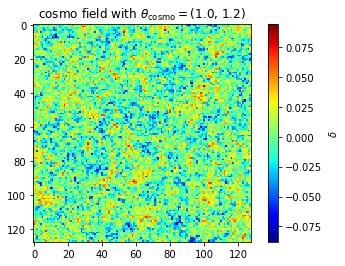

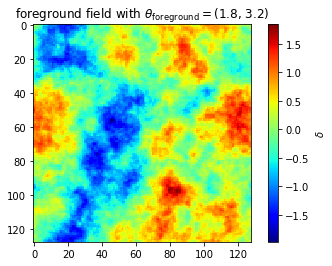

(<Figure size 432x288 with 2 Axes>, None)

In [10]:
generator = GenerateCosmoField(input_shape=(1,128,128), θ_fg=np.array([1.8, 3.2]))

θ_target = np.array([1, 1.2])[np.newaxis, :]
θ_fg = np.array([1.8, 3.2])[np.newaxis, :]
target_data = generator.simulator(
    parameters=θ_target,
    θ_fg=np.squeeze(θ_fg),
    save_fg_copy=True,
    seed=37,
    simulator_args={"input_shape": generator.input_shape})

generator.plot_data(target_data, pars=np.array([θ_target,θ_fg]), plot_fg=True, label="Observed data")

In [11]:
# define fiducial parameters and create data vector, d
θ_fid = np.array([1, 0.5]) # scale, power
θ_fg = np.array([1.8, 3.2])

In [12]:
SN = GenerateCosmoField(n_s=100, n_d=100, input_shape=(1,128,128), θ_fid=θ_fid, θ_fg=θ_fg)
# this is where we'd load in data if we didn't have a simulator
details, fiducial, validation_fiducial, derivative, validation_derivative = SN.generate_data()  

/mnt/home/tmakinen/anaconda3/envs/pyimnn/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in power


b0 shape :  (100, 1, 128, 128)


In [13]:
print("fiducial = {}\nvalidation_fiducial = {}\nderivative = {}\nvalidation_derivative = {}".format(
    fiducial.shape, validation_fiducial.shape, derivative.shape, validation_derivative.shape))

fiducial = (100, 1, 128, 128)
validation_fiducial = (100, 1, 128, 128)
derivative = (100, 2, 2, 1, 128, 128)
validation_derivative = (100, 2, 2, 1, 128, 128)


Now le but: We want to know firstly how well IMNN can tackle this problem, given a fiducial model to train on. Goals for right now:


1.   Train IMNN on fiducial parameters (set $\theta_{\rm fid} = (1.0, 0.5)$)
2.   Add foreground power spectrum on top



In [14]:
def fiducial_loader(seed, data):
    yield data[seed], seed

def derivative_loader(seed, derivative, parameter, data):
    yield data[seed, derivative, parameter], (seed, derivative, parameter)

# NN model
We're going to construct a neural network model for processing the gaussian $128 \times 128$ fields akin to the one in [Paco's paper](https://arxiv.org/pdf/2011.05992.pdf). Instead of dogs, cats, boats, and birds, we'll condense down to $\theta$, our simulation parameters (no pooling):

![model](https://missinglink.ai/wp-content/uploads/2019/07/A-Convolutional-Neural-Network.png)

In [19]:
model = tf.keras.Sequential(
    [tf.keras.Input(shape=SN.input_shape[:]),
     tf.keras.layers.Reshape(SN.input_shape[::-1]),
     tf.keras.layers.Conv2D(16,3, strides=2, padding='same'),
     tf.keras.layers.LeakyReLU(0.2),
     tf.keras.layers.Conv2D(32,3, strides=2, padding='same'),
     tf.keras.layers.LayerNormalization(),
     tf.keras.layers.LeakyReLU(0.2),
     tf.keras.layers.Conv2D(64,3, strides=2, padding='same'),
     tf.keras.layers.LayerNormalization(),
     tf.keras.layers.LeakyReLU(0.2),
     tf.keras.layers.Conv2D(128,3, strides=2, padding='same'),
     tf.keras.layers.LayerNormalization(),
     tf.keras.layers.LeakyReLU(0.2),
     tf.keras.layers.Conv2D(256,3, strides=2, padding='same'),
     tf.keras.layers.LayerNormalization(),
     tf.keras.layers.LeakyReLU(0.2),
     tf.keras.layers.Conv2D(512,3, strides=2, padding='same'),
     tf.keras.layers.LayerNormalization(),
     tf.keras.layers.LeakyReLU(0.2),
     tf.keras.layers.Reshape((512*2*2,)),
     tf.keras.layers.Dense(SN.n_summaries), 
    ])
opt = tf.keras.optimizers.Adam()

In [16]:
opt = tf.keras.optimizers.Adam()

In [27]:
imnn = IMNN.IMNN(n_s=SN.n_s, n_d=SN.n_d, n_params=SN.n_params, n_summaries=SN.n_summaries,
                 model=None, optimiser=opt, θ_fid=θ_fid, δθ=np.array([0.1,0.1]), input_shape=SN.input_shape,
                 fiducial=lambda x : fiducial_loader(x, fiducial), 
                 derivative=lambda x, y, z : derivative_loader(x, y, z, derivative), 
                 validation_fiducial=lambda x : fiducial_loader(x, validation_fiducial),
                 validation_derivative=lambda x, y, z : derivative_loader(x, y, z, validation_derivative), 
                 at_once=SN.n_s, check_shape=True, verbose=True,
                 directory="model", filename="cosmo+fg", save=True, load=True)

imnn.model.compile(opt)

input shape will be (1, 128, 128)


In [28]:
imnn.model.weights[0][0]

<tf.Tensor: shape=(3, 1, 16), dtype=float32, numpy=
array([[[ 0.051,  0.08 ,  0.083, -0.108, -0.039,  0.059, -0.039, -0.164,
          0.06 , -0.071, -0.01 , -0.142, -0.007,  0.01 , -0.133,  0.057]],

       [[-0.098,  0.191,  0.143, -0.157,  0.103,  0.025,  0.192,  0.031,
         -0.167, -0.11 , -0.108, -0.125,  0.096,  0.162,  0.026,  0.185]],

       [[ 0.138,  0.14 ,  0.047,  0.142,  0.037, -0.15 ,  0.141,  0.099,
         -0.158, -0.024,  0.126, -0.169,  0.17 , -0.184, -0.104, -0.035]]],
      dtype=float32)>

In [82]:
imnn.fit(patience=10, min_iterations=100, tqdm_notebook=False, checkpoint=10)







Iterations: 0it [00:00, ?it/s]

Using patience length of 10. Maximum number of training iterations is 10000000000.
Saving current model in model/cosmo+fg


KeyboardInterrupt: 

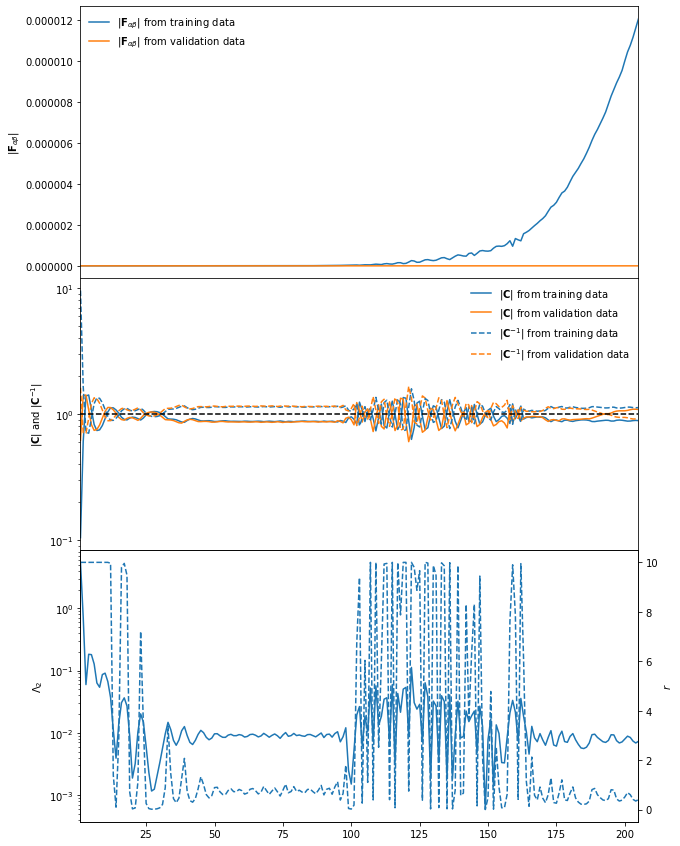

In [78]:
imnn.plot()

In [25]:
θ_fg

array([[1.8, 3.2]])

/mnt/home/tmakinen/anaconda3/envs/pyimnn/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in power


(<Figure size 432x288 with 2 Axes>, None)

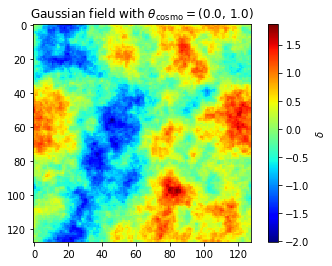

In [26]:
generator = GenerateCosmoField()

θ_target = np.array([2.0, 0.8])[np.newaxis, :]
θ_fg = np.array([1.8, 3.2])[np.newaxis, :]

target_data = generator.simulator(
    parameters=θ_target,
    θ_fg=θ_fg,
    seed=37,
    simulator_args={"input_shape": generator.input_shape})

generator.plot_data(target_data, label="Observed data")

In [55]:
prior = tfd.Blockwise([tfd.Uniform(0.1, 8),
                       tfd.Uniform(0.1, 5.)])

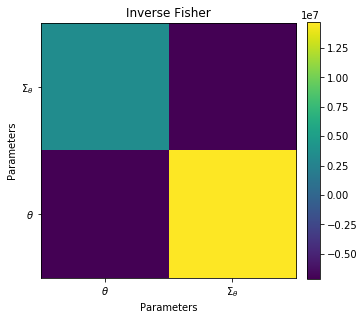

In [56]:
GA = LFI.GaussianApproximation(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    labels=[r"$\theta$", r"$\Sigma_\theta$"])

GA.plot_Fisher(figsize=(5, 5));


In [33]:
imnn.F**-1

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 5620.392, 11598.909],
       [11598.91 , 23897.975]], dtype=float32)>

/mnt/home/tmakinen/repositories/imnn/IMNN/LFI/LFI.py:233: RuntimeWarning: invalid value encountered in true_divide
  (grid[i_][1] - grid[i_][0]))
/mnt/home/tmakinen/repositories/imnn/IMNN/LFI/LFI.py:252: RuntimeWarning: invalid value encountered in true_divide
  (grid[j_][1] - grid[j_][0]))
/mnt/home/tmakinen/anaconda3/envs/pyimnn/lib/python3.7/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/mnt/home/tmakinen/anaconda3/envs/pyimnn/lib/python3.7/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/mnt/home/tmakinen/anaconda3/envs/pyimnn/lib/python3.7/site-packages/matplotlib/contour.py:1200: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/mnt/home/tmakinen/anaconda3/envs/pyimnn/lib/python3.7/site-packages/matplotlib/contour.py:1200: RuntimeWarning: invalid valu

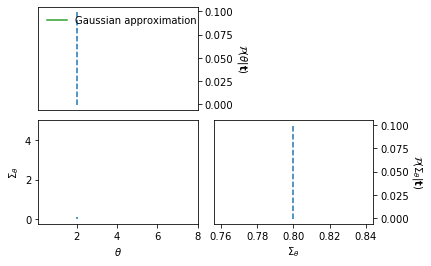

In [57]:
ax = GA.plot(
    gridsize=(1000, 1000),
    color="C2",
    label="Gaussian approximation");

ax[0][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--')
ax[1][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--')

#ax[0][1].plot(np.ones(10)*np.pi/2, np.linspace(-0.001,0.05, 10))
ax[1][1].plot(np.ones(10)*θ_target[0][1], np.linspace(-0.001,0.1, 10), linestyle='--')

In [47]:
# run ABC computation
ABC = LFI.ApproximateBayesianComputation(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    simulator=lambda x : SN.simulator(
        x, None, {"input_shape": SN.input_shape}),
    labels=[r"$A$", r"$B$"])

LinAlgError: Singular matrix

/mnt/home/tmakinen/anaconda3/envs/pyimnn/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in power


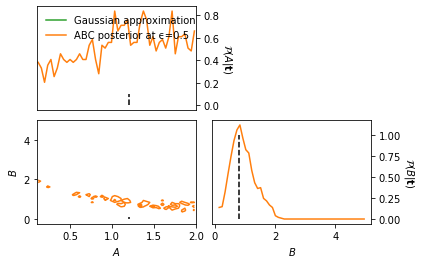

In [71]:
ax = GA.plot(
    gridsize=(1000, 1000),
    color="C2",
    label="Gaussian approximation");
ABC.plot(
    ϵ=1.0,
    accepted=1000,
    draws=4000,
    ax=ax,
    color="C1",
    label="ABC posterior at ϵ={}".format(0.5),
    smoothing=0,
    bins=50);


ax[0][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--', color='k')
ax[1][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--', color='k')

ax[1][1].plot(np.ones(10)*θ_target[0][1], np.linspace(-0.001,1., 10), linestyle='--', color='k')

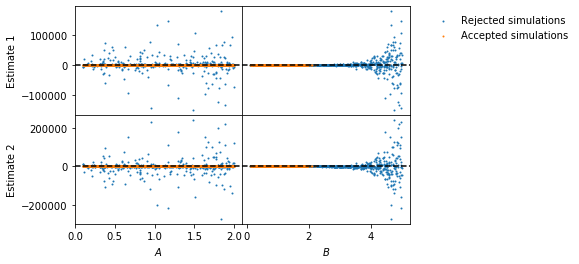

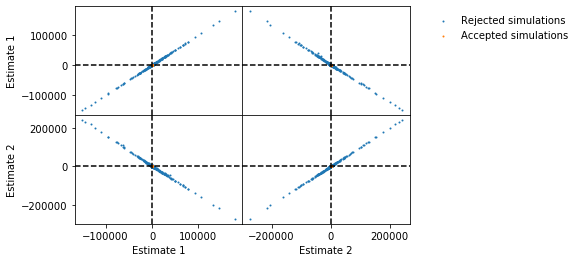

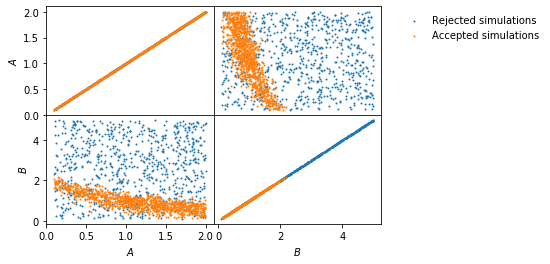

In [72]:
ABC.scatter_plot(axes="parameter_estimate", rejected=0.01);
ABC.scatter_plot(axes="estimate_estimate", rejected=0.01);
ABC.scatter_plot(axes="parameter_parameter", rejected=0.01);

In [51]:
SN = GenerateCosmoField(n_s=1000, n_d=1000, input_shape=(1,128,128), θ_fid=θ_fid, θ_fg=np.squeeze(θ_fg))


In [60]:
PMC = LFI.PopulationMonteCarlo(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    simulator=lambda x : SN.simulator(
        x, θ_fg=np.squeeze(θ_fg), seed=None, save_fg_copy=False, simulator_args={"input_shape": SN.input_shape}),
    labels=[r"$A$", r"$B$"])

In [61]:
PMC.PMC(draws=5000, initial_draws=8000, criterion=0.5, tqdm_notebook=False)

/mnt/home/tmakinen/anaconda3/envs/pyimnn/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in power



Iterations: 0it [00:00, ?it/s]


Iterations: 1it [00:13, 13.15s/it]


Iterations: 1it [00:13, 13.15s/it, criterion=[1.865], draws=[2681.], ε=[1.327]]


Iterations: 3it [00:29, 11.64s/it, criterion=[1.865], draws=[2681.], ε=[1.327]]


Iterations: 3it [00:29, 11.64s/it, criterion=[1.467], draws=[6089.], ε=[1.037]]


Iterations: 6it [00:51, 10.32s/it, criterion=[1.467], draws=[6089.], ε=[1.037]]


Iterations: 6it [00:51, 10.32s/it, criterion=[1.06], draws=[10806.], ε=[0.824]]


Iterations: 10it [01:20,  9.42s/it, criterion=[1.06], draws=[10806.], ε=[0.824]]


Iterations: 10it [01:20,  9.42s/it, criterion=[0.765], draws=[17343.], ε=[0.668]]


Iterations: 15it [01:57,  8.83s/it, criterion=[0.765], draws=[17343.], ε=[0.668]]


Iterations: 15it [01:57,  8.83s/it, criterion=[0.594], draws=[25755.], ε=[0.553]]


Iterations: 21it [02:45,  8.57s/it,

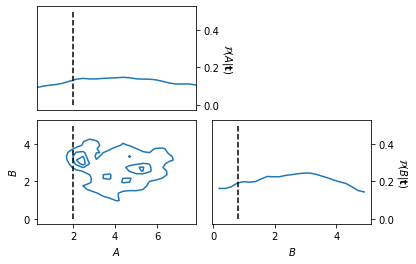

In [62]:
ax = PMC.plot(smoothing=1)
ax[0][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.5, 10), linestyle='--', color='k')
ax[1][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,5, 10), linestyle='--', color='k')

ax[1][1].plot(np.ones(10)*θ_target[0][1], np.linspace(-0.001,.5, 10), linestyle='--', color='k')


/mnt/home/tmakinen/repositories/imnn/cosmo-field/make_2Dfield.py:57: RuntimeWarning: divide by zero encountered in power
  return amp*np.power(k, -n)


IndexError: too many indices for array

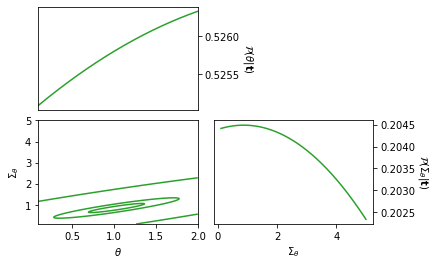

In [69]:
ax = GA.plot(
    gridsize=(1000, 1000),
    color="C2",
    label=None);

# ax = ABC.plot(
#     gridsize=(1000, 1000),
#     ϵ=0.5,
#     accepted=2000,
#     draws=100000,
#     ax=ax,
#     color="C1",
#     label="ABC posterior at ϵ={}".format(0.5),
#     smoothing=0,
#     bins=50);

PMC.plot(
    draws=5000,
    initial_draws=8000,
    criterion=1,
    percentile=75,
    ax=ax,
    color="C3",
    label="PMC posterior",
    smoothing=1,
    bins=50);

ax[0][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--', color='k')
ax[1][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--', color='k')

ax[1][1].plot(np.ones(10)*θ_target[0][1], np.linspace(-0.001,1., 10), linestyle='--', color='k')


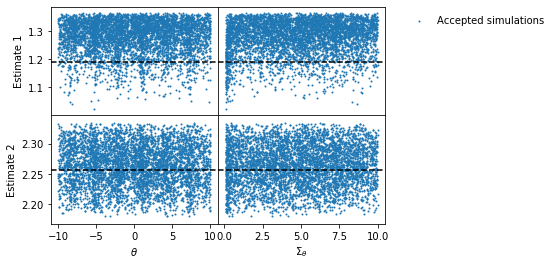

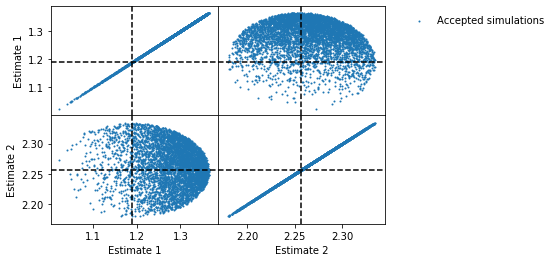

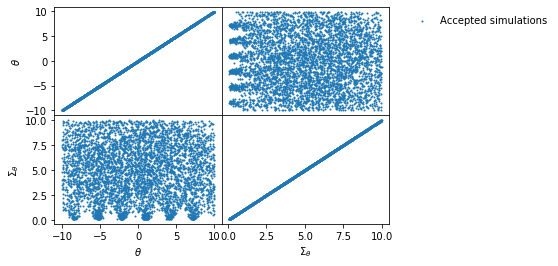

In [100]:
PMC.scatter_plot(axes="parameter_estimate")
PMC.scatter_plot(axes="estimate_estimate")
PMC.scatter_plot(axes="parameter_parameter")

In [120]:
def curve(t, rate, dims=5, sig=0.5, active_dims=1):
    nd = len(t)
    d = np.zeros((dims, nd))
    for i,dim in enumerate(d[:-active_dims]):
        if i%2 == 0:
            d[i, :] = np.ones(nd)*np.sin(t) + np.random.normal(scale=sig, size=t.shape)
        else:
            d[i, :] = np.ones(nd)*np.cos(t) + np.random.normal(scale=sig, size=t.shape)
    for i in range(active_dims):
        d[-(i+1), :] = t*(rate + np.random.normal(scale=sig, size=t.shape)) #np.exp(-t/rate)
    return d

In [125]:
t = np.linspace(0, 30, 100)
rate = 0.5
c = curve(t, rate, dims=4, active_dims=4)

In [126]:
c.shape

(4, 100)

No handles with labels found to put in legend.


(100, 4)


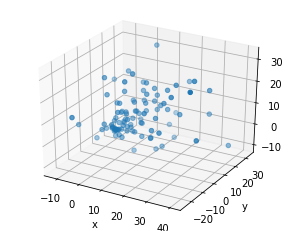

In [127]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(111, projection='3d')
print(c.T.shape)
#xs,ys,zs = data.T[::3], data.T[1::3], data.T[2::3]
xs,ys = c[2:4]
zs = c[-3]
ax.scatter(xs, ys, zs, zdir='z', s=20, c=None, depthshade=True)

ax.legend(frameon=False)
# ax.set_xticks([])
# ax.set_zticks([])
ax.set_xlabel("x");
ax.set_ylabel("y");
ax.set_zlabel("z");

In [130]:
np.cov(c).shape

(4, 4)

In [131]:
np.linalg.inv(np.cov(c))

array([[ 0.012,  0.   , -0.004, -0.   ],
       [ 0.   ,  0.014, -0.003, -0.   ],
       [-0.004, -0.003,  0.011, -0.001],
       [-0.   , -0.   , -0.001,  0.011]])

Traceback (most recent call last):
  File "/mnt/home/tmakinen/anaconda3/bin/conda", line 12, in <module>
    from conda.cli import main
ModuleNotFoundError: No module named 'conda'


In [15]:
import py21cmfast as p21c

In [29]:
coeval8, coeval9, coeval10 = p21c.run_coeval(
    redshift = [8.0, 9.0, 10.0],
    user_params = {"HII_DIM": 100, "BOX_LEN": 100, "USE_INTERPOLATION_TABLES": True},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    astro_params = p21c.AstroParams({"HII_EFF_FACTOR":20.0}),
    random_seed=12345
)

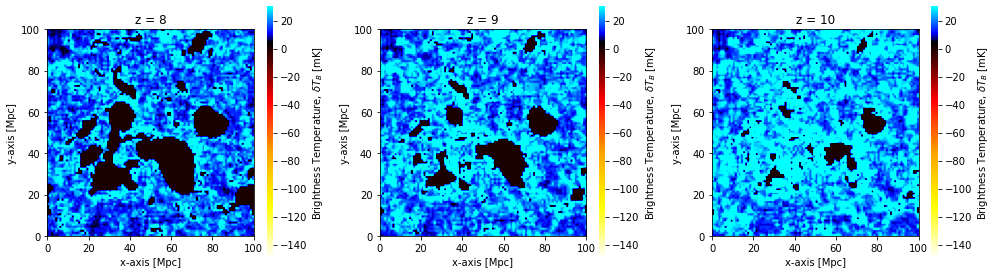

In [31]:
fig, ax = plt.subplots(1,3, figsize=(14,4))
for i, (coeval, redshift) in enumerate(zip([coeval8, coeval9, coeval10], [8,9,10])):
    p21c.plotting.coeval_sliceplot(coeval, ax=ax[i], fig=fig);
    plt.title("z = %s"%redshift)
plt.tight_layout()

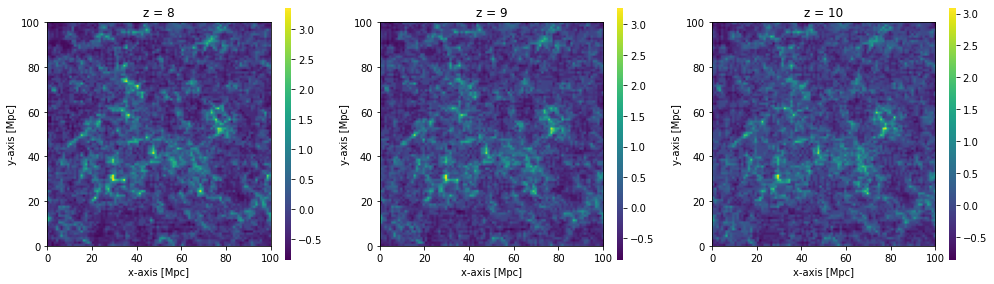

In [32]:
fig, ax = plt.subplots(1,3, figsize=(14,4))
for i, (coeval, redshift) in enumerate(zip([coeval8, coeval9, coeval10], [8,9,10])):
    p21c.plotting.coeval_sliceplot(coeval, kind='density', ax=ax[i], fig=fig);
    plt.title("z = %s"%redshift)
plt.tight_layout()